In [1]:
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import ThreadPoolExecutor
import gc
import os as os
from tqdm.notebook import tqdm
import cupy as cp
import tkinter as tk
from tkinter import filedialog
from tkinter import simpledialog
import pandas as pd
from m2stitch import stitch_images
from basicpy import BaSiC, metrics
from glob import glob
from skimage.io.collection import alphanumeric_key
import shutil
from hyperactive import Hyperactive
import numpy as np
from skimage.io import imread 
from skimage.io import imsave
from skimage import io
from skimage import util
from skimage import exposure
import numpy as np
import matplotlib.pyplot as plt
import jax
import pickle
from itertools import chain, repeat
import subprocess
from datetime import datetime
import imagej, scyjava
import logging
from typing import List
from skimage.transform import resize as skresize
from scipy.fftpack import dct, idct
current_dateTime = datetime.now()

In [2]:
image_dir ="C:/Users/smith6jt/KINTSUGI/data/1904_CC2B28_raw"
stitch_dir = "C:/Users/smith6jt/KINTSUGI/data/1904_CC2B28_BaSiC_Stitched"
meta_dir = "C:/Users/smith6jt/KINTSUGI/data/1904_CC2B28_meta"
print(f"Image folder is {image_dir}.")
print(f"Stitching folder is {stitch_dir}.")
print(f"Meta folder is {meta_dir}.")

Image folder is C:/Users/smith6jt/KINTSUGI/data/1904_CC2B28_raw.
Stitching folder is C:/Users/smith6jt/KINTSUGI/data/1904_CC2B28_BaSiC_Stitched.
Meta folder is C:/Users/smith6jt/KINTSUGI/data/1904_CC2B28_meta.


In [3]:
# cycle_folder = filedialog.askdirectory()
cycle_folder = "C:/Users/smith6jt/KINTSUGI/data/1904_CC2B28_raw/cyc001"

zplane = 8 
channel = 2

# image_file name below is derived from 1_000tt_Z0zz_CHc.tif where tt is the tile number with one leading zero, zz is the z-position with one leading zero, and c is the channel number.
image_file = f'1_000??_Z0{str(zplane).zfill(2)}_CH{channel}.tif'
print(f"Using {cycle_folder}/{image_file}")

#Convert to numpy array
im_raw = sorted(glob(os.path.join(cycle_folder, image_file)), key = alphanumeric_key)
im = io.imread_collection(im_raw)
im_array_init = np.asarray(im)
print(f"Image shape is {im_array_init.shape} and type is {im_array_init.dtype}\nMin value is {im_array_init.min()} and max value is {im_array_init.max()}")

Using C:/Users/smith6jt/KINTSUGI/data/1904_CC2B28_raw/cyc001/1_000??_Z008_CH2.tif
Image shape is (63, 1440, 1920) and type is uint16
Min value is 0 and max value is 4855


In [4]:
RESIZE_ORDER = 1
RESIZE_MODE = "symmetric"
PRESERVE_RANGE = True
OUTPUT_IMAGE = "OutputImage"

def _resize_images_list(images_list: List, side_size: float = None, x_side_size: float = None, y_side_size: float = None):
    if side_size is not None:
        y_side_size = x_side_size = side_size
    resized_images_list = []
    for i, im in enumerate(images_list):
        if im.shape[0] != x_side_size or im.shape[1] != y_side_size:
            resized_images_list.append(skresize(
                im, 
                (x_side_size, y_side_size), 
                order = RESIZE_ORDER, 
                mode = RESIZE_MODE,
                preserve_range = PRESERVE_RANGE
                )
            )
        else:
            resized_images_list.append(im)
    return resized_images_list

In [5]:
_saved_size = im[0].shape
working_size = 128
nrows = ncols = working_size

downsized_image = np.dstack(_resize_images_list(images_list=im, side_size=working_size))
print(f"Downsized image shape is {downsized_image.shape} and type is {downsized_image.dtype}\nMin value is {downsized_image.min()} and max value is {downsized_image.max()}")

Downsized image shape is (128, 128, 63) and type is float64
Min value is 100.11630717478822 and max value is 2771.1888579166134


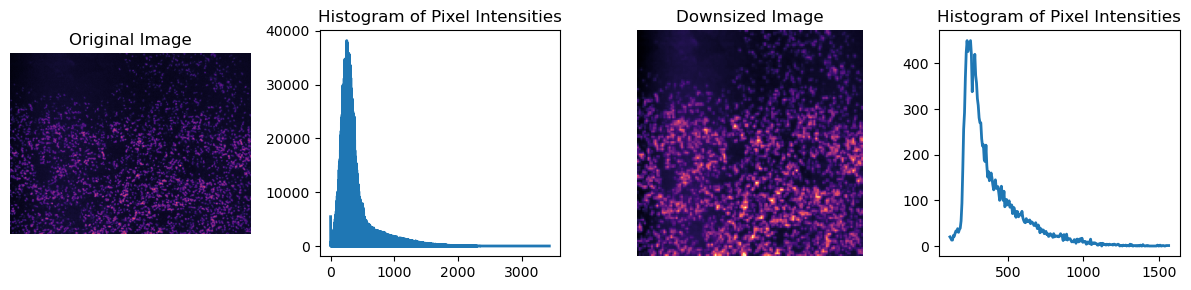

In [6]:
i = 40

hist, hist_centers = exposure.histogram(im_array_init[i])
hist2, hist_centers2 = exposure.histogram(downsized_image[:,:,i])
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].imshow(im_array_init[i], cmap='magma')
axes[0].set_title('Original Image')
axes[0].set_axis_off()
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('Histogram of Pixel Intensities')
axes[2].imshow(downsized_image[:,:,i], cmap='magma')
axes[2].set_title('Downsized Image')
axes[2].set_axis_off()
axes[3].plot(hist_centers2, hist2, lw=2)
axes[3].set_title('Histogram of Pixel Intensities')
fig.tight_layout()

In [7]:
mean_image = np.mean(downsized_image, axis=2)
mean_div = mean_image/np.mean(mean_image)

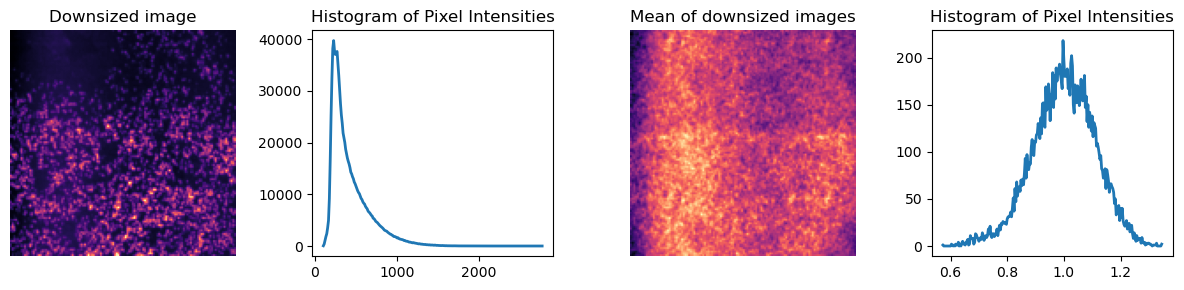

In [8]:
i = 40

hist, hist_centers = exposure.histogram(downsized_image)
hist2, hist_centers2 = exposure.histogram(mean_div)
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].imshow(downsized_image[:,:,i], cmap='magma')
axes[0].set_title('Downsized image')
axes[0].set_axis_off()
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('Histogram of Pixel Intensities')
axes[2].imshow(mean_div, cmap='magma')
axes[2].set_title('Mean of downsized images')
axes[2].set_axis_off()
axes[3].plot(hist_centers2, hist2, lw=2)
axes[3].set_title('Histogram of Pixel Intensities')
fig.tight_layout()

In [9]:
def _dct2d(mtrx: np.array):
    """
    Calculates 2D discrete cosine transform.
    
    Parameters
    ----------
    mtrx
        Input matrix.  
        
    Returns
    -------    
    Discrete cosine transform of the input matrix.
    """
     
    # Check if input object is 2D.
    if mtrx.ndim != 2:
        raise ValueError("Passed object should be a matrix or a numpy array with dimension of two.")

    return dct(dct(mtrx.T, norm='ortho').T, norm='ortho')

In [ ]:
Dis_Cos_Trans_mean = _dct2d(mean_div.T)

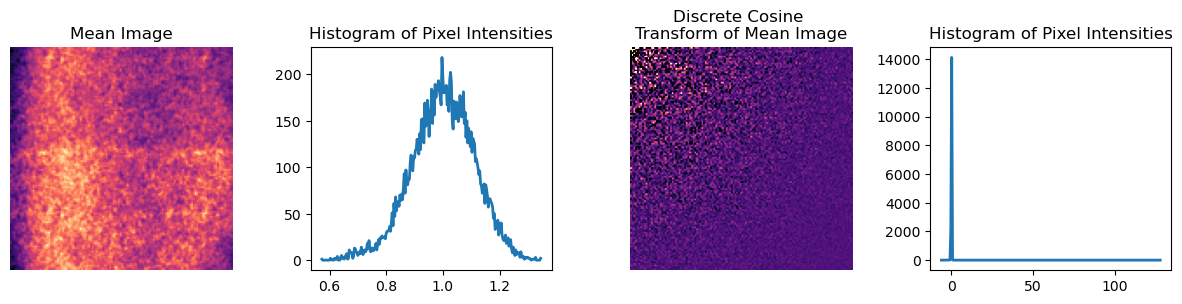

In [11]:
hist, hist_centers = exposure.histogram(mean_div)
hist2, hist_centers2 = exposure.histogram(Dis_Cos_Trans_mean)
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].imshow(mean_div, cmap='magma')
axes[0].set_title('Mean Image')
axes[0].set_axis_off()
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('Histogram of Pixel Intensities')
axes[2].imshow(Dis_Cos_Trans_mean, cmap='magma', vmin=-0.1, vmax=0.3)
axes[2].set_title('Discrete Cosine \nTransform of Mean Image')
axes[2].set_axis_off()
axes[3].plot(hist_centers2, hist2, lw=2)
axes[3].set_title('Histogram of Pixel Intensities')
fig.tight_layout()

In [12]:
def _idct2d(mtrx: np.array):
    """
    Calculates 2D inverse discrete cosine transform.
    
    Parameters
    ----------
    mtrx
        Input matrix.  
        
    Returns
    -------    
    Inverse of discrete cosine transform of the input matrix.
    """
     
    # Check if input object is 2D.
    if mtrx.ndim != 2:
        raise ValueError("Passed object should be a matrix or a numpy array with dimension of two.")
 
    return idct(idct(mtrx.T, norm='ortho').T, norm='ortho')

def _shrinkageOperator(matrix, epsilon):
    temp1 = matrix - epsilon
    temp1[temp1 < 0] = 0
    temp2 = matrix + epsilon
    temp2[temp2 > 0] = 0
    res = temp1 + temp2
    return res

def _inexact_alm_rspca_l1(
    images, 
    lambda_flatfield, 
    if_darkfield, 
    lambda_darkfield, 
    optimization_tolerance, 
    max_iterations,
    weight=None, 
    ):

    if weight is not None and weight.size != images.size:
            raise IOError('weight matrix has different size than input sequence')

    # Shape variables
    p = images.shape[0]           # Image height
    q = images.shape[1]           # Image width
    m = p*q                       # Total pixels per image
    n = images.shape[2]          # Number of images
    images = np.reshape(images, (m, n), order='F')

    if weight is not None:
        weight = np.reshape(weight, (m, n), order='F')
    else:
        weight = np.ones_like(images)

    # SVD and Norm variables    
    _, svd, _ = np.linalg.svd(images, full_matrices=False) # SVD decomposition
    norm_two = svd[0] # Largest singular value
    d_norm = np.linalg.norm(images, ord='fro') # Frobenius norm of images

    # Optimization parameters
    dual_var_lowrank = 0 # Dual variable for low-rank component (Y1)
    lagrange_mult1 = 1 # Lagrange multiplier for first constraint (ent1)
    lagrange_mult2 = 10 # Lagrange multiplier for second constraint (ent2)
    penalty_factor = 12.5 / norm_two # (mu)
    penalty_factor_bar = penalty_factor * 1e7 # Upper bound for penalty (mu_bar)
    scale_ratio = 1.5 # Scale factor for penalty updates

    # Component matrices
    A1_hat = np.zeros_like(images) # Estimated flat-field
    A1_coeff = np.ones((1, images.shape[1])) # Flat-field coefficients
    E1_hat = np.zeros_like(images) # Estimated error/noise
    W_hat = _dct2d(np.zeros((p, q)).T) # DCT coefficients

    # Offset and mask variables
    A_offset = np.zeros((m, 1)) # Offset for flatfield
    B1_uplimit = np.min(images) # Upper limit for darkfield
    B1_offset = 0 # Darkfield offset
    A_inmask = np.zeros((p, q)) # Inner mask for optimization
    # Mask covers central region (5/6 x 5/6)
    A_inmask[int(np.round(p / 6) - 1): int(np.round(p*5 / 6)), int(np.round(q / 6) - 1): int(np.round(q * 5 / 6))] = 1

    # main iteration loop starts
    iter = 0
    total_svd = 0
    converged = False

    while not converged:
 
        iter += 1

        if len(A1_coeff.shape) == 1:
            A1_coeff = np.expand_dims(A1_coeff, 0)
        if len(A_offset.shape) == 1:
            A_offset = np.expand_dims(A_offset, 1)

        W_idct_hat = _idct2d(W_hat.T)
        A1_hat = np.dot(np.reshape(W_idct_hat, (-1,1), order='F'), A1_coeff) + A_offset

        temp_W = (images - A1_hat - E1_hat + (1 / penalty_factor) * dual_var_lowrank) / lagrange_mult1
        temp_W = np.reshape(temp_W, (p, q, n), order='F')
        temp_W = np.mean(temp_W, axis=2)

        W_hat = W_hat + _dct2d(temp_W.T)
        W_hat = np.maximum(W_hat - lambda_flatfield / (lagrange_mult1 * penalty_factor), 0) + np.minimum(W_hat + lambda_flatfield / (lagrange_mult1 * penalty_factor), 0)
        W_idct_hat = _idct2d(W_hat.T)

        if len(A1_coeff.shape) == 1:
            A1_coeff = np.expand_dims(A1_coeff, 0)
        if len(A_offset.shape) == 1:
            A_offset = np.expand_dims(A_offset, 1)

        A1_hat = np.dot(np.reshape(W_idct_hat, (-1,1), order='F'), A1_coeff) + A_offset
        E1_hat = images - A1_hat + (1 / penalty_factor) * dual_var_lowrank / lagrange_mult1
        E1_hat = _shrinkageOperator(E1_hat, weight / (lagrange_mult1 * penalty_factor))
        R1 = images - E1_hat
        A1_coeff = np.mean(R1, 0) / np.mean(R1)
        A1_coeff[A1_coeff < 0] = 0

        if if_darkfield:
            validA1coeff_idx = np.where(A1_coeff < 1)

            B1_coeff = (np.mean(R1[np.reshape(W_idct_hat, -1, order='F') > np.mean(W_idct_hat) - 1e-6][:, validA1coeff_idx[0]], 0) - \
            np.mean(R1[np.reshape(W_idct_hat, -1, order='F') < np.mean(W_idct_hat) + 1e-6][:, validA1coeff_idx[0]], 0)) / np.mean(R1)
            k = np.array(validA1coeff_idx).shape[1]
            temp1 = np.sum(A1_coeff[validA1coeff_idx[0]]**2)
            temp2 = np.sum(A1_coeff[validA1coeff_idx[0]])
            temp3 = np.sum(B1_coeff)
            temp4 = np.sum(A1_coeff[validA1coeff_idx[0]] * B1_coeff)
            temp5 = temp2 * temp3 - temp4 * k
            if temp5 == 0:
                B1_offset = 0
            else:
                B1_offset = (temp1 * temp3 - temp2 * temp4) / temp5

            B1_offset = np.maximum(B1_offset, 0)
            B1_offset = np.minimum(B1_offset, B1_uplimit / np.mean(W_idct_hat))
            B_offset = B1_offset * np.reshape(W_idct_hat, -1, order='F') * (-1)
            B_offset = B_offset + np.ones_like(B_offset) * B1_offset * np.mean(W_idct_hat)

            A1_offset = np.mean(R1[:, validA1coeff_idx[0]], axis=1) - np.mean(A1_coeff[validA1coeff_idx[0]]) * np.reshape(W_idct_hat, -1, order='F')
            A1_offset = A1_offset - np.mean(A1_offset)
            A_offset = A1_offset - np.mean(A1_offset) - B_offset

            # smooth A_offset
            W_offset = _dct2d(np.reshape(A_offset, (p,q), order='F').T)
            W_offset = np.maximum(W_offset - lambda_darkfield / (lagrange_mult2 * penalty_factor), 0) + \
                np.minimum(W_offset + lambda_darkfield / (lagrange_mult2 * penalty_factor), 0)
            A_offset = _idct2d(W_offset.T)
            A_offset = np.reshape(A_offset, -1, order='F')

            # encourage sparse A_offset
            A_offset = np.maximum(A_offset - lambda_darkfield / (lagrange_mult2 * penalty_factor), 0) + \
                np.minimum(A_offset + lambda_darkfield / (lagrange_mult2 * penalty_factor), 0)
            A_offset = A_offset + B_offset


        Z1 = images - A1_hat - E1_hat # Constraint violation
        dual_var_lowrank = dual_var_lowrank + penalty_factor * Z1 # Dual variable updates
        penalty_factor = np.minimum(penalty_factor * scale_ratio, penalty_factor_bar)
        
        # Stop Criterion
        stopCriterion = np.linalg.norm(Z1, ord='fro') / d_norm
        print(f'Iteration {iter}, stopCriterion: {stopCriterion}')
        if stopCriterion < optimization_tolerance:
            converged = True

        if not converged and iter >= max_iterations:
            converged = True
    A_offset = np.squeeze(A_offset)
    A_offset = A_offset + B1_offset * np.reshape(W_idct_hat, -1, order='F')
    return A1_hat, E1_hat, A_offset

def _resize_image(image: np.ndarray, side_size: float  = None, x_side_size: float = None, y_side_size: float = None):
    if side_size is not None:
        y_side_size = x_side_size = side_size
    if image.shape[0] != x_side_size or image.shape[1] != y_side_size:
        return skresize(
            image,
            (x_side_size, y_side_size), 
            order = RESIZE_ORDER, 
            mode = RESIZE_MODE,
            preserve_range = PRESERVE_RANGE
        )
    else:
        return image

In [13]:
XAoffset = np.zeros((nrows, ncols))
weight = np.ones(downsized_image.shape)
eplson = 0.1
if_darkfield = True
reweighting_iter = 0
flag_reweighting = True
flatfield_last = np.ones((nrows, ncols))
darkfield_last = np.random.randn(nrows, ncols)

sorted_images = np.sort(downsized_image, axis=2)

lambda_flatfield = np.sum(np.abs(Dis_Cos_Trans_mean)) / 400 * 0.5
lambda_darkfield = lambda_flatfield * 0.2

while flag_reweighting:
    reweighting_iter += 1

    initial_flatfield = False
    if initial_flatfield:
        raise IOError('Initial flatfield option not implemented yet!')
    else:
        X_k_A, X_k_E, X_k_Aoffset = _inexact_alm_rspca_l1(
            images = sorted_images, 
            lambda_flatfield = lambda_flatfield,
            if_darkfield = if_darkfield, 
            lambda_darkfield = lambda_darkfield, 
            optimization_tolerance = 1e-6, 
            max_iterations = 500,
            weight=weight
        )

    XA = np.reshape(X_k_A, [nrows, ncols, -1], order='F')
    XE = np.reshape(X_k_E, [nrows, ncols, -1], order='F')
    XAoffset = np.reshape(X_k_Aoffset, [nrows, ncols], order='F')
    XE_norm = XE / np.mean(XA, axis=(0, 1))

    weight = np.ones_like(XE_norm) / (np.abs(XE_norm) + eplson)

    weight = weight * weight.size / np.sum(weight)

    temp = np.mean(XA, axis=2) - XAoffset
    flatfield_current = temp / np.mean(temp)
    darkfield_current = XAoffset
    mad_flatfield = np.sum(np.abs(flatfield_current - flatfield_last)) / np.sum(np.abs(flatfield_last))
    temp_diff = np.sum(np.abs(darkfield_current - darkfield_last))
    
    if temp_diff < 1e-7:
        mad_darkfield = 0
    else:
        mad_darkfield = temp_diff / np.maximum(np.sum(np.abs(darkfield_last)), 1e-6)

    print(f"Re-weighting iteration {reweighting_iter}: MAD flatfield = {mad_flatfield}; MAD darkfield = {mad_darkfield}")
    flatfield_last = flatfield_current
    darkfield_last = darkfield_current
    if np.maximum(mad_flatfield,
                    mad_darkfield) <= 1.0e-3 or \
            reweighting_iter >= 25:
        flag_reweighting = False

shading = np.mean(XA, 2) - XAoffset
flatfield = _resize_image(
    image = shading, 
    x_side_size = _saved_size[0], 
    y_side_size = _saved_size[1]
)
flatfield = flatfield.astype(np.float64)  # Ensure floating point
flatfield = np.clip(flatfield, 1e-6, None)  # Prevent division by zero
flatfield = flatfield / np.mean(flatfield[flatfield > 0])

if if_darkfield:
    darkfield = _resize_image(
        image = XAoffset, 
        x_side_size = _saved_size[0], 
        y_side_size = _saved_size[1]
    )
else:
    darkfield = np.zeros_like(flatfield)

Iteration 1, stopCriterion: 0.7669555185990495
Iteration 2, stopCriterion: 0.1415503860282537
Iteration 3, stopCriterion: 0.1415503860282537
Iteration 4, stopCriterion: 0.1415503860282537
Iteration 5, stopCriterion: 0.1415503860282537
Iteration 6, stopCriterion: 0.13000398055929469
Iteration 7, stopCriterion: 0.12565637352121492
Iteration 8, stopCriterion: 0.11993881840682682
Iteration 9, stopCriterion: 0.1162311755044476
Iteration 10, stopCriterion: 0.11011458150226573
Iteration 11, stopCriterion: 0.09860844410552028
Iteration 12, stopCriterion: 0.08336823527051732
Iteration 13, stopCriterion: 0.06595570861493553
Iteration 14, stopCriterion: 0.049463810862908415
Iteration 15, stopCriterion: 0.03565225054128466
Iteration 16, stopCriterion: 0.025161886761161826
Iteration 17, stopCriterion: 0.01727595997149156
Iteration 18, stopCriterion: 0.011287160464979783
Iteration 19, stopCriterion: 0.007023142162465143
Iteration 20, stopCriterion: 0.004189406884084078
Iteration 21, stopCriterion: 0

Pre re-weighting flatfield image shape is (128, 128, 63) and type is float64
Min value is 106.1811896082948 and max value is 1397.2966199971409
Error image shape is (128, 128, 63) and type is float64
Min value is -615.0854998235191 and max value is 1620.709256228819


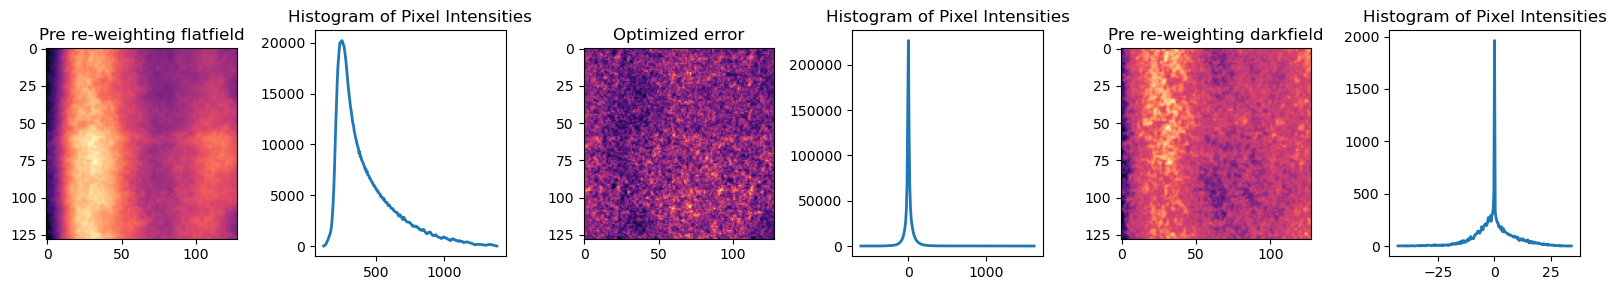

In [14]:
print(f"Pre re-weighting flatfield image shape is {XA.shape} and type is {XA.dtype}\nMin value is {XA.min()} and max value is {XA.max()}")
print(f"Error image shape is {XE.shape} and type is {XE.dtype}\nMin value is {XE.min()} and max value is {XE.max()}")
hist, hist_centers = exposure.histogram(XA)
hist2, hist_centers2 = exposure.histogram(XE)
hist3, hist_centers3 = exposure.histogram(XAoffset)
fig, axes = plt.subplots(1, 6, figsize=(16, 3))
axes[0].imshow(XA[:,:,i], cmap='magma')
axes[0].set_title('Pre re-weighting flatfield') 
axes[0].set_axis_on()
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('Histogram of Pixel Intensities')
axes[2].imshow(XE[:,:,i], cmap='magma')
axes[2].set_title('Optimized error')
axes[2].set_axis_on()
axes[3].plot(hist_centers2, hist2, lw=2)
axes[3].set_title('Histogram of Pixel Intensities')
axes[4].imshow(XAoffset, cmap='magma')
axes[4].set_title('Pre re-weighting darkfield')
axes[4].set_axis_on()
axes[5].plot(hist_centers3, hist3, lw=2)
axes[5].set_title('Histogram of Pixel Intensities')
fig.tight_layout()

Flatfield image shape is (1440, 1920) and type is float64
Min value is 0.6805011158921258 and max value is 1.2045346634920893
Darkfield image shape is (1440, 1920) and type is float64
Min value is -42.794995038942155 and max value is 34.17239985665637


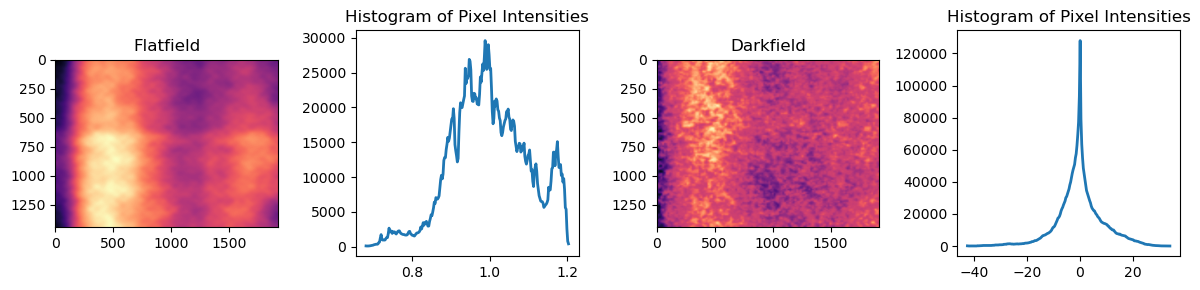

In [15]:
print(f"Flatfield image shape is {flatfield.shape} and type is {flatfield.dtype}\nMin value is {flatfield.min()} and max value is {flatfield.max()}")
print(f"Darkfield image shape is {darkfield.shape} and type is {darkfield.dtype}\nMin value is {darkfield.min()} and max value is {darkfield.max()}")
hist, hist_centers = exposure.histogram(flatfield)
hist2, hist_centers2 = exposure.histogram(darkfield)
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].imshow(flatfield, cmap='magma')
axes[0].set_title('Flatfield')
axes[0].set_axis_on()
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('Histogram of Pixel Intensities')
axes[2].imshow(darkfield, cmap='magma')
axes[2].set_title('Darkfield')
axes[2].set_axis_on()
axes[3].plot(hist_centers2, hist2, lw=2)
axes[3].set_title('Histogram of Pixel Intensities')
fig.tight_layout()

In [20]:
corrected = np.zeros_like(im_array_init)

for i in range(len(im_array_init)):
    corrected[i] = (((im_array_init[i].astype(np.float64)) - darkfield) / flatfield)
    corrected[i] = np.clip(corrected[i], im_array_init[i].min(), (im_array_init[i].max()))

Original image shape is (63, 1440, 1920) and type is uint16
Min value is 0 and max value is 4855
Corrected image shape is (63, 1440, 1920) and type is uint16
Min value is 0 and max value is 4855


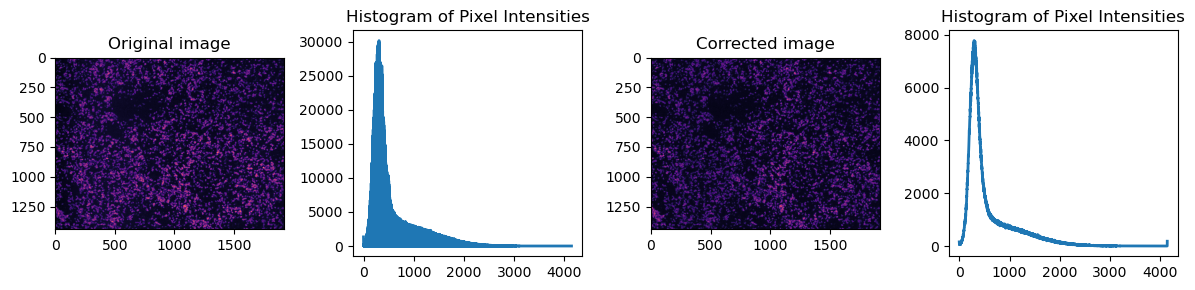

In [21]:
i=15
print(f"Original image shape is {im_array_init.shape} and type is {im_array_init.dtype}\nMin value is {im_array_init.min()} and max value is {im_array_init.max()}")
print(f"Corrected image shape is {corrected.shape} and type is {corrected.dtype}\nMin value is {corrected.min()} and max value is {corrected.max()}")
hist, hist_centers = exposure.histogram(im_array_init[i])
hist2, hist_centers2 = exposure.histogram(corrected[i])
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].imshow(im_array_init[i], cmap='magma')
axes[0].set_title('Original image')
axes[0].set_axis_on()
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('Histogram of Pixel Intensities')
axes[2].imshow(corrected[i], cmap='magma', vmax=5000)
axes[2].set_title('Corrected image')
axes[2].set_axis_on()
axes[3].plot(hist_centers2, hist2, lw=2)
axes[3].set_title('Histogram of Pixel Intensities')
fig.tight_layout()

In [319]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft2, fftshift
from skimage import img_as_float
from skimage.color import rgb2gray
from skimage.filters import window
from scipy import ndimage, fftpack, stats
from matplotlib import pyplot as plt
from math import floor
# import radial_profile as radprof

def calculate_power_spectrum(image, normalize_power=False):
    """
    A function that is used to calculate a centered 2D power spectrum.
    Additionally the power spectrum can be normalized by image dimensions
    and image intensity mean, if necessary.
    """
    power = np.abs(fftpack.fftshift(fftpack.fft2(image[:]))) ** 2
    if normalize_power:
        dims = image[:].shape[0] * image[:].shape[1]
        mean = np.mean(image[:])
        power = power / (dims * mean)

    return power

In [325]:
power_im1 = calculate_power_spectrum(im_array_init[35])
power_im_norm1 = calculate_power_spectrum(im_array_init[35], normalize_power=True)

In [321]:
def calculate_summed_power(power, pix_size, show_plots):
    """
    Calculate a 1D power spectrum fro 2D power spectrum, by summing all rows and
    columns, and then summing negative and positive frequencies, to form a
    N/2+1 long 1D array. This approach is significantly faster to calculate
    than the radial average.
    """

    # Sum along rows and columns separately
    sum_rows = np.sum(power, axis=0)  # Sum along rows
    sum_cols = np.sum(power, axis=1)  # Sum along columns
    
    # Interpolate to make both arrays the same length
    target_length = max(sum_rows.size, sum_cols.size)
    x_rows = np.linspace(0, 1, sum_rows.size)
    x_cols = np.linspace(0, 1, sum_cols.size)
    x_new = np.linspace(0, 1, target_length)
    
    sum_rows_interp = np.interp(x_new, x_rows, sum_rows)
    sum_cols_interp = np.interp(x_new, x_cols, sum_cols)
    
    # Now we can safely add the interpolated arrays
    sum = sum_rows_interp + sum_cols_interp

    zero = floor(float(sum.size) / 2)
    sum[zero + 1:] = sum[zero + 1:] + sum[:zero - 1][::-1]
    sum = sum[zero:]
    dx = pix_size
    f_k = np.linspace(0, 1, sum.size) * (1.0 / (2 * dx))

    simple_power = [f_k, sum]

    if show_plots:
        plt.plot(simple_power[0], simple_power[1], linewidth=2, color="red")
        plt.ylabel("Total power")
        plt.yscale('log')
        plt.xlabel('Frequency')
        plt.show()

    return f_k, sum

In [ ]:
pixel_size = 4.19
frequencies1, power_spectrum_1d1 = calculate_summed_power(power_im1, pixel_size, show_plots=True)
# f_k1, profile1 = calculate_radial_average(signal_image_tiff, bin_size=2)

In [327]:
power_im = calculate_power_spectrum(corrected[35])
power_im_norm = calculate_power_spectrum(corrected[35], normalize_power=True)

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
ax = axes.ravel()
ax[0].set_title("Original image")
ax[0].imshow(im_array_init[35], cmap='magma')
ax[1].set_title("Original Power Spectrum")
ax[1].imshow(np.log(power_im1), cmap='magma')
ax[2].set_title("Original Power Spectrum Norm")
ax[2].imshow(np.log(power_im_norm1), cmap='magma')

ax[3].set_title("Corrected Image")
ax[3].imshow(corrected[35], cmap='magma')
ax[4].set_title("Corrected Power Spectrum")
ax[4].imshow(np.log(power_im), cmap='magma')
ax[5].set_title("Corrected Power Spectrum Norm")
ax[5].imshow(np.log(power_im_norm), cmap='magma')
plt.show()

## 3.2 Stitching

Here we stitch the original and corrected tiles for comparison.  This is accomplished using the package m2stitch.  Enter the number of rows and columns, and overlap percentage known from your data.  The "pou" stands for percent overlap uncertainty and is the sole parameter that can be changed to affect stitching quality.  The rows and columns functions are for generating lists corresponding to a "snake by rows" pattern starting at the upper left of the image.  They will need to be changed for other stitching patterns.

To save and reuse stitching results, uncomment/comment out the appropriate lines.  The results are saved to the metadata folder defined above.

Be sure to closely evaluate the areas of overlap for stitching quality.  The cells below allow for visualizing in this notebook and for saving to inspect elsewhere.

For more information see https://github.com/yfukai/m2stitch

In [ ]:
n = 9  # Number of rows (height)
m = 7 # Number of columns (width)
overlap_percentage = 0.30

pou = 13
stitch_model = os.path.join(meta_dir, "result.pkl")

# Row coordinates: each row index is repeated m times
rows = list(chain.from_iterable(repeat(row, m) for row in range(n)))

# Column coordinates: snake pattern for each row, going back and forth
cols = list(chain.from_iterable(
    range(m) if row % 2 == 0 else range(m - 1, -1, -1) for row in range(n)
))
result_df, _ = stitch_images(im_array, rows, cols, initial_ncc_threshold = 0, overlap_percentage=overlap_percentage, pou=pou, max_cores=10)
result_df.to_pickle(stitch_model)

If the cell above has already been run to create a stitching model, run the cell below to apply it to the original images.

In [17]:
stitch_model = os.path.join(meta_dir, "result.pkl")

result_df = pd.read_pickle(stitch_model)

result_df["y_pos2"] = result_df["y_pos"] - result_df["y_pos"].min()
result_df["x_pos2"] = result_df["x_pos"] - result_df["x_pos"].min()

size_y = im_array_z.shape[1]
size_x = im_array_z.shape[2]

stitched_image_size = (
    result_df["y_pos2"].max() + size_y,
    result_df["x_pos2"].max() + size_x,
)
stitched_image = np.zeros_like(im_array_z, shape=stitched_image_size)
for i, row in result_df.iterrows():
    stitched_image[
        row["y_pos2"] : row["y_pos2"] + size_y,
        row["x_pos2"] : row["x_pos2"] + size_x,
    ] = im_array_z[i]

Visualize the result of stitching the original tiles.

In [ ]:
   
# stitched_image = stitched_image.astype(np.uint16)
# x1 = 1810
# x2 = 2050
# y1 = 1330
# y2 = 1650
fig, axes = plt.subplots(figsize=(12, 9))
im = axes.imshow(stitched_image, vmax=None)
# im = axes.imshow(stitched_image[y1:y2,x1:x2], vmax=None)
fig.colorbar(im)
fig.tight_layout()

Save the stitched image if desired.

In [ ]:

raw_image_file_path = os.path.join(meta_dir, "test_original.tif") 
imsave(raw_image_file_path, stitched_image_2)

Reuse the stitching model to stitch the corrected tiles.

In [19]:

result_df=pd.read_pickle(stitch_model)
result_df["y_pos2"] = result_df["y_pos"] - result_df["y_pos"].min()
result_df["x_pos2"] = result_df["x_pos"] - result_df["x_pos"].min()

size_y = images_transformed_z.shape[1]
size_x = images_transformed_z.shape[2]

stitched_image_size = (
    result_df["y_pos2"].max() + size_y,
    result_df["x_pos2"].max() + size_x,
)
stitched_image_basic = np.zeros_like(images_transformed_z, shape=stitched_image_size)
for i, row in result_df.iterrows():
    stitched_image_basic[
        row["y_pos2"] : row["y_pos2"] + size_y,
        row["x_pos2"] : row["x_pos2"] + size_x,
    ] = images_transformed_z[i]

Visualize the result of stitching the corrected tiles.  Comment/uncomment the coordinates to crop.

In [ ]:
# x1 = 6000
# x2 = 8000
# y1 = 0000
# y2 = 3000
fig, axes = plt.subplots(figsize=(12, 9))
# im = axes.imshow(stitched_image_basic[y1:y2,x1:x2])
im = axes.imshow(stitched_image_basic, vmax=None)
fig.colorbar(im)
fig.tight_layout()

Save the corrected stitched image if desired.

In [ ]:
# stitched_image_basic_re = exposure.rescale_intensity(stitched_image_basic, in_range=(np.min(stitched_image_basic), np.max(stitched_image_basic)), out_range=(0, 65535)).astype(np.uint16)
result_image_file_path = os.path.join(meta_dir, "test_corrected.tif") 
imsave(result_image_file_path, stitched_image_basic_re, check_contrast=False)

Before testing deconvolution, you must correct and stitch an entire z-stack.  For this you can run the cells above for each image in the stack, or use B_IllumCor_Stitching_Decon.ipynb

## 3.3 Deconvolution

The following cell has multiple parameters related to the microscope used to aquire the images and the images themselves.  Once these are input, the testing is primarily to tune the number of iterations/stop_crit necessary to get good results.  The damping and hist_clip further can improve results.  There is no need to supply a point-spread function.  Finally, finding the optimal use of computing resources on GPU or CPU is accomplished via the max_GPU and max_CPU parameters.  There is no limit to image size.  If the images are too large to fit in the specified memory maximums, the will be split into blocks and processed sequentially.

Be sure the MATLAB Runtime v9.5 (R2018, 64-bit) is installed.  Download for free here: http://www.mathworks.com/products/compiler/mcr/index.html. Reboot your computer after install.  

The image_dir and stitch_dir definitions used previously will be again used here, and a new folder will be created to save the deconvolved images.  

The original deconvolution program was for lightsheet images and modified to use with widefield fluorescence.  See https://www.nature.com/articles/s41598-019-53875-y 

Output will be written to the terminal.  Check that the first image stack is processed without error.  If there is an "Maximum variable size allowed on the device is exceeded." error, then restart the kernel, decrease the max_GPU or max_CPU parameter, rerun the decon function cell, and try again.

In [ ]:
dec_cycles = 1
dec_channels = 1

# pixel size in xy dimension (nanometers)
xy_vox = 377
# pixel size in z dimension (nanometers)
z_vox = 1500
# Number of iterations of Lucy-Richardson algo before stopping unless stop_crit is met first
iterations = 25
# Microscope objective numerical aperture
mic_NA = 0.75
# Refractive index of tissue being imaged
tissue_RI = 1.3
# Opening size in millimeters of objective aperture
slit_aper = 6.5
# Focal length in millimeters of objective
f_cyl = 1
# Used to reduce noise.  Increase value for noisy images. (0-10)
damping = 0
# If set, the deconvolved images will be clipped by this percent for max and min values, and then scaled to full range of bit depth. (0-5)
hist_clip = 0.010
# Percent change between iterations to use as criteria to stop deconvolution.
stop_crit = 5.00
# Enter 1 to perform on GPU, 0 to use CPU
GPU = 1
# Percent maximum GPU memory to use if GPU = 1
max_GPU = 45
# Percent maximum RAM to use if GPU = 0
max_CPU = 20
if GPU == 1:
    max_block=max_GPU
elif GPU == 0:
    max_block=max_CPU
# The excitation and emission wavelength in nanometers
ex = 358
em = 461

decon_exe = os.path.join(os.path.dirname(image_dir), "LsDeconv.exe")
decon_dir = stitch_dir.replace('_BaSiC_Stitched', '_Decon')
source = os.path.join(stitch_dir, f"cyc{str(dec_cycles).zfill(2)}", f"CH{str(dec_channels)}")
dest = os.path.join(decon_dir, f"cyc{str(dec_cycles).zfill(2)}", f"CH{str(dec_channels)}")
os.makedirs(dest, exist_ok=True)

subprocess.run([decon_exe, source, str(xy_vox), str(z_vox), str(iterations), str(mic_NA), str(tissue_RI), str(ex), str(em), str(f_cyl), str(slit_aper), str(damping), str(hist_clip), str(stop_crit), str(max_block), str(GPU)])
gc.collect()
try:
    os.rename(os.path.join(source, 'deconvolved'), os.path.join(dest, 'deconvolved'))
except (FileNotFoundError):
    print("Reduce max memory.")

The following cell will compare the original to the deconvolved image.

In [ ]:
# Enter the cycle, channel, and z-plane for the image you want to evaluate.
c = 5
ch = 3
z = 8

# Crop the image by entering the x and y coordinates below.
x1 = 400
x2 = 1000
y1 = 600
y2 = 1200

source_image = imread(os.path.join(stitch_dir, f"cyc{str(c).zfill(2)}", f"CH{str(ch)}", f"{str(z).zfill(2)}.tif"))
dest = os.path.join(stitch_dir.replace('_BaSiC_Stitched', '_Decon'), f"cyc{str(c).zfill(2)}", f"CH{str(ch)}")
fig, axes = plt.subplots(1, 2, figsize=(24, 18))
im = axes[0].imshow(source_image[x1:x2,y1:y2])
fig.colorbar(im, shrink=0.5, ax=axes[0])
axes[0].set_title("Original")
decon_image = imread(os.path.join(dest, 'deconvolved', f"deconv_0000{str(z).zfill(2)}.tif"))
im = axes[1].imshow(decon_image[x1:x2,y1:y2])
fig.colorbar(im, shrink=0.5, ax=axes[1])
axes[1].set_title("Deconvolved")
fig.tight_layout()

You may now use the optimized parameters in the next notebook to process large datasets.

## 4 FIJI Clij2 plugin - EDF

The following section connects this notebook with a local installation of FIJI and a Clij2 plugin to run an Extended Depth of Focus (EDF) projection along the deconvolved image stack.  The image calculation is done on the GPU for efficient processing.  In the next cell enter the amount of memory (no more than 80% of system RAM is a good rule of thumb) to allow for the computation.  Also, enter the name of the GPU, and the parameters for the EDF calculation.  A new folder will be created for the results, and the image can be inspected in another program and in the next section.

### 4.1 EDF on GPU

In [ ]:
ij_mem = 40
edf_cycles = 1
edf_channels = 1
GPU_name = "NVIDIA RTX A4500"
radius_x = 5.0
radius_y = 5.0
sigma = 20.0

scyjava.config.add_option(f'-Xmx{str(ij_mem)}g')
ij = imagej.init('C:/Users/smith6jt/Fiji.app')

macro = """
#@ File in_folder
#@ String device
#@ File out_folder
#@ Integer radius_x
#@ Integer radius_y
#@ Integer sigma

File.openSequence(in_folder);
run("CLIJ2 Macro Extensions", "cl_device=[" + device + "]");
Ext.CLIJ_clear();
image1 = "deconvolved";
Ext.CLIJ2_push(image1);
image2 = "extended_depth_of_focus_variance_projection";
radius_x = 5.0;
radius_y = 5.0;
sigma = 20.0;
Ext.CLIJ2_extendedDepthOfFocusVarianceProjection(image1, image2, radius_x, radius_y, sigma);
Ext.CLIJ2_pull(image2);
selectImage(image1);
close();
selectImage(image2);
saveAs("Tiff", out_folder + File.separator + "EDF.tif");
"""
decon_dir = stitch_dir.replace('_BaSiC_Stitched', '_Decon')
edf_dir = decon_dir.replace('_Decon', '_EDF')
edf_source = os.path.join(decon_dir, f"cyc{str(edf_cycles).zfill(2)}", f"CH{str(edf_channels)}", "deconvolved")
edf_dest = os.path.join(edf_dir, f"cyc{str(edf_cycles).zfill(2)}", f"CH{str(edf_channels)}")
os.makedirs(edf_dest, exist_ok=True)

args ={'in_folder': edf_source, "cl_device" : GPU_name, "out_folder" : edf_dest, "radius_x" : 5.0, "radius_y" : 5.0, "sigma" : 20.0}
ij.py.run_macro(macro, args)

### 4.2 EDF comparison with deconvolution images

Visualize the results with periodic z-planes.

In [ ]:
decon_stack = sorted(glob(os.path.join(edf_source, f"deconv_0000??.tif")), key=alphanumeric_key)
decon_stack = io.imread_collection(decon_stack)
decon_image = np.asarray(decon_stack)
edf_result = imread(os.path.join(edf_dest, "EDF.tif"))

x1 = 2400
x2 = 3000
y1 = 2000
y2 = 3000

fig, axes = plt.subplots(2, 3, figsize=(18, 8))
im = axes[0,0].imshow(decon_image[6][x1:x2,y1:y2])
axes[0,0].set_title("decon_z007")
im = axes[0,1].imshow(decon_image[7][x1:x2,y1:y2])
axes[0,1].set_title("decon_z008")
im = axes[0,2].imshow(decon_image[8][x1:x2,y1:y2])
axes[0,2].set_title("decon_z009")
im = axes[1,0].imshow(decon_image[9][x1:x2,y1:y2])
axes[1,0].set_title("decon_z010")
im = axes[1,1].imshow(decon_image[10][x1:x2,y1:y2])
axes[1,1].set_title("decon_z011")
im = axes[1,2].imshow(edf_result[x1:x2,y1:y2])
axes[1,2].set_title("EDF_var_x5y5_sigma20")
fig.tight_layout()

Visualize the results as a full image.

In [ ]:
edf_result = imread(os.path.join(edf_dest, "EDF.tif"))
fig, axes = plt.subplots(figsize=(24, 18))
im = axes.imshow(edf_result)
fig.colorbar(im)
fig.tight_layout()